# Принятие решений в бизнесе на примере интернет-магазина

Имеются данные о гипотезах по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort, а также файлы с результатами А/В теста.

**Задача:** приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты для увеличения выручки крупного интернет-магазина. 

## Загрузка данных и подготовка их к анализу

In [5]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings # помогает управлять нежелательными предупреждениями в программе
# конвертеры, которые позволяют использовать типы pandas в matplotlib, обеспечивает корректное отображение данных времени на графиках  
register_matplotlib_converters()

In [6]:
# Загружаем данные о гипотезах, заказах и посетителях из CSV-файлов в переменные.
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') # гипотезы
    orders = pd.read_csv('/datasets/orders.csv') # заказы
    visitors = pd.read_csv('/datasets/visitors.csv') # посетители
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [7]:
pd.set_option('display.max_colwidth', None) # настройка отображения всего текста в столбцах

# Применение стилей для выравнивания текста по левому краю в первом столбце
display(hypothesis.style.set_properties(**{'text-align': 'left'}, subset=['Hypothesis']))

hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [8]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков в строках всех датафреймов не обнаружено.
Названия столбцов датафреймов содержат заглавные буквы, приведем их к стандартному виду.

In [11]:
#замена заглавных букв на строчные
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

# проверка стиля написания в наименовании столбцов
display(hypothesis.columns, orders.columns) 

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

Типы данных во всех колонках соответствуют сохранённым в них значениям, кроме столбцов с датой.
Приведем их к формату datetime64 вместо object

In [13]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [14]:
display(orders.dtypes, visitors.dtypes) # убедимся, что типы столбцов соответствут их значениям

transactionid             int64
visitorid                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

date        datetime64[ns]
group               object
visitors             int64
dtype: object

In [15]:
# Проверим датафреймы orders и visitors на наличие дубликатов
display(orders.duplicated().sum(), 
       visitors.duplicated().sum())

0

0

Явных дубликатов не обнаружено.

Проверим, есть ли пользователи, оказавшиеся одновременно в двух группах.

In [18]:
# Разделим данные таблицы orders на группы А и В
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']
# Посчитаем количество уникальных пользователей по группам
print('В группе "А"', ordersA['visitorid'].nunique(), 
      'уникальных пользователя, в группе "В"', ordersB['visitorid'].nunique(), 'уникальных пользователей.')

В группе "А" 503 уникальных пользователя, в группе "В" 586 уникальных пользователей.


In [19]:
# Выбираем пользователей, попавших в обе группы
users_in_both_groups = pd.merge(ordersA, ordersB, on='visitorid', how='inner')['visitorid'].unique()
display(users_in_both_groups)
print('Количество пользователей, попавших в обе группы:', users_in_both_groups.shape[0]) 

array([4069496402,  199603092, 3803269165, 2378935119,  237748145,
       4256040402, 2038680547, 1738359350, 2458001652, 3891541246,
       2716752286, 3656415546, 2686716486, 2954449915, 2927087541,
       3234906277,  457167155, 2579882178, 3957174400, 1648269707,
       2780786433,  818047933, 2044997962, 1959144690, 3202540741,
       1333886533,  351125977, 3951559397,  393266494, 3984495233,
       4120364173, 4266935830, 1230306981, 1294878855, 1614305549,
          8300375,  477780734, 1668030113, 3717692402, 3766097110,
       3941795274,  471551937, 1316129916, 1801183820, 1602967004,
       2587333274, 2600415354,  232979603, 3972127743, 1404934699,
        276558944, 3062433592, 2654030115, 3963646447, 4186807279,
       2712142231, 2949041841,  963407295], dtype=int64)

Количество пользователей, попавших в обе группы: 58


Удалим этих пользователей из обеих групп, чтобы избежать повторной ошибки логирования

In [21]:
orders = orders[~orders['visitorid'].isin(users_in_both_groups)]

In [22]:
# Посчитаем количество уникальных пользователей по группам, их должно быть на 58 меньше
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']
print('В группе "А"', ordersA['visitorid'].nunique(), 
      'уникальных пользователя, в группе "В"', ordersB['visitorid'].nunique(), 'уникальных пользователей.')

В группе "А" 445 уникальных пользователя, в группе "В" 528 уникальных пользователей.


***Датасеты подготовлены к работе: названия всех колонок записаны в едином стиле, пропуски и дубликаты отсутствуют, типы данных во всех колонках соответствуют сохранённым в них значениям, пересечений групп нет.***

## Приоритизация гипотез.

In [25]:
hypothesis.style.set_properties(**{'text-align': 'left'}, subset=['hypothesis'])

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк ICE для приоритизации гипотез. 

In [27]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

# Cортируем гипотезы по убыванию приоритета
sort_hypothesis = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

# Применение стилей для выравнивания текста по левому краю и округление до 3х знаков после запятой
sort_hypothesis.style.format({'ICE': '{:.3f}'}).set_properties(**{'text-align': 'left'}, subset=['hypothesis'])

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


***Наиболее перспективные гипотезы по ICE:   
    1. Запустить акцию, дающую скидку на товар в день рождения;  
    2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;  
    3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.***  
  
Средний приоритет у гипотез по ICE:  
    4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;  
    5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.

Применим фреймворк RICE для приоритизации гипотез. 

In [30]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

# Cортируем гипотезы по убыванию приоритета
sort_hypothesis = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

# Применение стилей для выравнивания текста по левому краю и округление до 3х знаков после запятой
sort_hypothesis.style.format({'RICE': '{:.3f}'}).set_properties(**{'text-align': 'left'}, subset=['hypothesis'])

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


***Наиболее перспективные гипотезы по RICE:   
        1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  
        2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;  
        3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.***  
  
Средний приоритет у гипотез по RICE:  
        4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;  
        5. Запустить акцию, дающую скидку на товар в день рождения.

***В тройку наиболее приоритетных гипотез как по ICE, так и по RICE вошли две гипотезы:*** 
- ***Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;***
- ***Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.***
  
На первое место в приоритете по RICE вышла гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", которая была третьей по ICE. Она затронет большее количество пользователей, так как её параметр `reach` 10 - максимально возможный.    

Лидирующая по ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения" оказалась лишь на 5-м месте в приоритете по RICE, т.к. затрагивает минимальное число клиентов (параметр `reach` равен 1).  

Гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" оказалась наиболее стабильной и по ICE (2 приоритет) и по RICE (3 приоритет). Её стоит обязательно протестировать.

## Анализ A/B-теста

In [34]:
# Считаем данные с результатами A/B тестирования
display(orders.head(), visitors.head())

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**Подготовка данных:** создадим агрегированные и кумулятивные данные для групп A и B по количеству заказов, выручке и количеству посетителей, а затем объединим их в один DataFrame.

In [36]:
# Фильтрация данных для группы A и переименование столбцов
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Вычисление кумулятивных данных для группы A по количеству пользователей
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# Фильтрация данных для группы B и переименование столбцов
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Вычисление кумулятивных данных для группы B по количеству пользователей
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Фильтрация данных по заказам для группы A и группировка по дате
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Вычисление кумулятивных данных для группы A по заказам и выручке
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# Фильтрация данных по заказам для группы B и группировка по дате
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# Вычисление кумулятивных данных для группы B по заказам и выручке
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# Объединение всех данных в один DataFrame
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Названия столбцов данных в датасете `data` (Группа В аналогично А):  
  
`ordersPerDateA` — количество заказов в выбранную дату в группе A;  

`revenuePerDateA` — суммарная выручка в выбранную дату в группе A;  

`ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;  

`revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;  

`visitorsPerDateA` — количество пользователей в выбранную дату в группе A;  

`visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A

**3.1. Построение графика кумулятивной выручки по группам.**

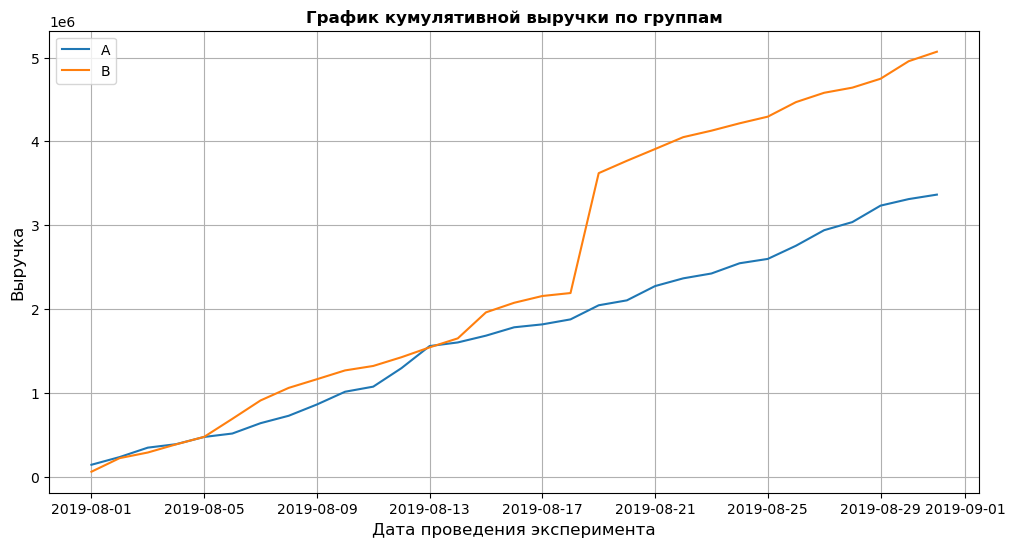

In [39]:
# Задаем размер графика
plt.figure(figsize=(12, 6))

# Строим график выручки группы А
plt.plot(data['date'], data['revenueCummulativeA'], label='A')

# Строим график выручки группы B
plt.plot(data['date'], data['revenueCummulativeB'], label='B')

plt.title('График кумулятивной выручки по группам', fontsize=12, fontweight="bold")
plt.xlabel('Дата проведения эксперимента', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

На протяжении почти всего теста группа В лидировала с незначительным отрывом, однако во второй половине месяца проведения эксперимента призошел резкий скачек выручки группы В, и затем линии были практически параллельны до окончания эксперимента.   
Возможно на результат повлиял аномальный всплеск числа заказов, либо появление очень дорогих заказов в выборке В. 

**3.2. Построение графика кумулятивного среднего чека по группам.**

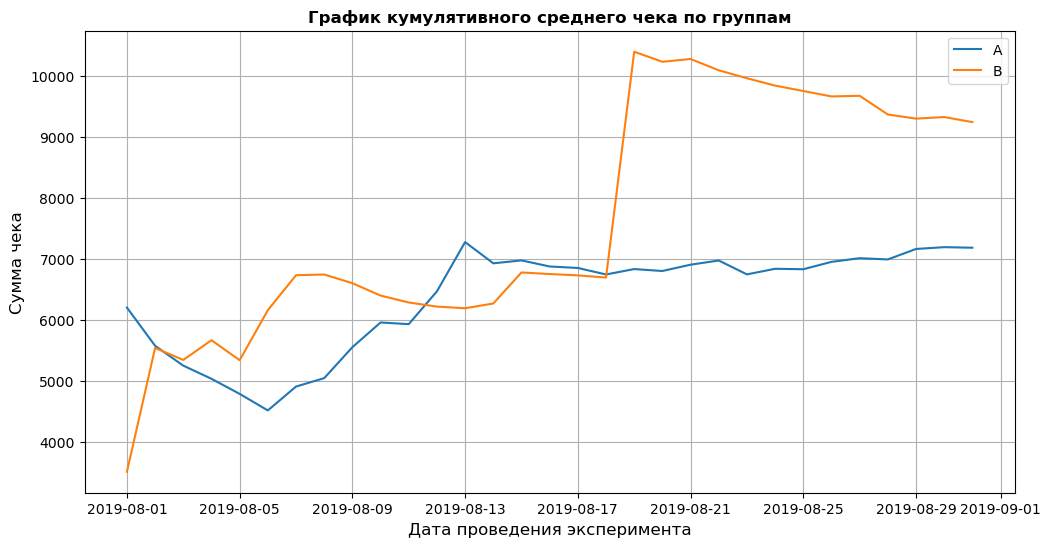

In [42]:
# Задаем размер графика
plt.figure(figsize=(12, 6))

# Строим графики, для этого разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(data['date'], data['revenueCummulativeA']/data['ordersCummulativeA'], label='A')
plt.plot(data['date'], data['revenueCummulativeB']/data['ordersCummulativeB'], label='B')

plt.title('График кумулятивного среднего чека по группам', fontsize=12, fontweight="bold")
plt.xlabel('Дата проведения эксперимента', fontsize=12)
plt.ylabel('Сумма чека', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Средний чек ближе к концу теста установился для группы А. В группе В, как и для куммулятивной выручки, наблюдается резкий скачек среднего чека во второй половине месяца, а также значительное увеличение суммы чека в первой декаде месяца. Возможно, в группу B попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

**3.3. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A.**

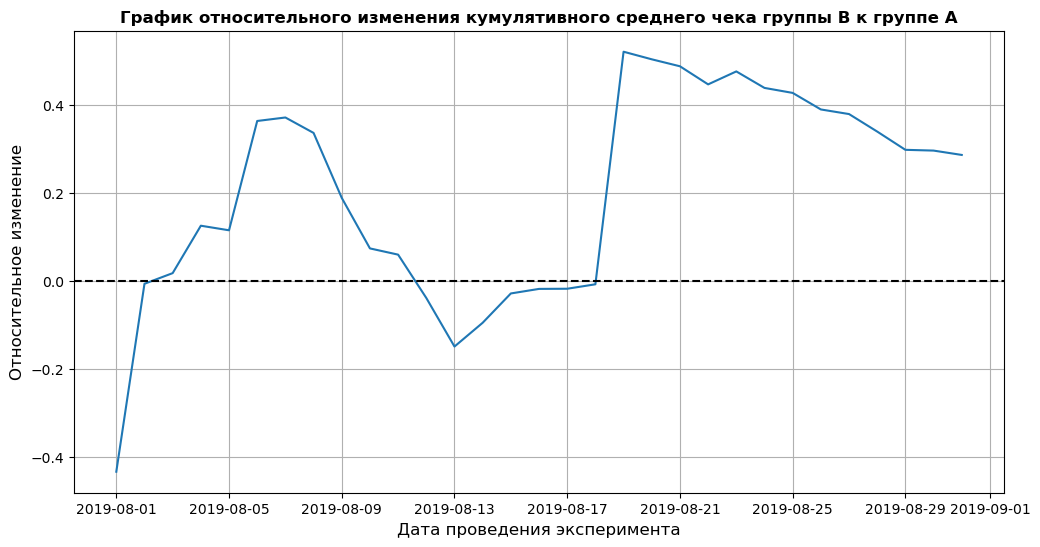

In [45]:
# Задаем размер графика
plt.figure(figsize=(12, 6))

# cтроим отношение средних чеков
plt.plot(data['date'], 
         (data['revenueCummulativeB']/data['ordersCummulativeB'])/
         (data['revenueCummulativeA']/data['ordersCummulativeA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=12, fontweight="bold")
plt.xlabel('Дата проведения эксперимента', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.grid(True)
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Самый резкий скачек наблюдается 19 августа. Видимо именно тогда были совершены аномальные заказы. 

Кроме того, значительное преобладание среднего чека заметно в период с 6 по 8 августа. В этот период при постепенном росте величины среднего чека в группе В наблюдался значительный спад в группе А, что в относительных величинах дает пик на графике.

**3.4. Построение графика кумулятивного среднего количества заказов на посетителя по группам.**

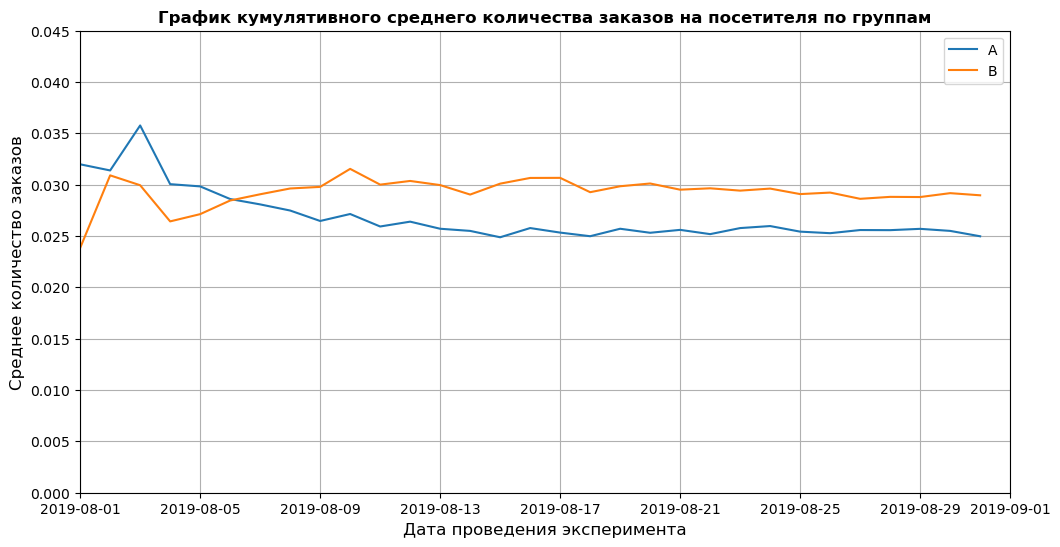

In [48]:
# считаем среднее количество заказов на посетителя группы А
data['conversionA'] = data['ordersCummulativeA'] / data['visitorsCummulativeA']

# считаем среднее количество заказов на посетителя группы B
data['conversionB'] = data['ordersCummulativeB'] / data['visitorsCummulativeB']

# Задаем размер графика
plt.figure(figsize=(12, 6))

# строим графики
plt.plot(data['date'], data['conversionA'], label='A')
plt.plot(data['date'], data['conversionB'], label='B')

# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.045]) 

plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize=12, fontweight="bold")
plt.xlabel('Дата проведения эксперимента', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

В начале теста сегмент А лидировал по кумулятивному среднему количеству заказов, но затем у группы В среднее количество заказов вырвалось вперёд и зафиксировалось, а у группы А — просело, но тоже зафиксировалось. Абсолютное значение колебания в начале и в конце теста небольшое. Тестовая группа лидирует по кумулятивному среднему количеству заказов. 

**3.5. Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.**

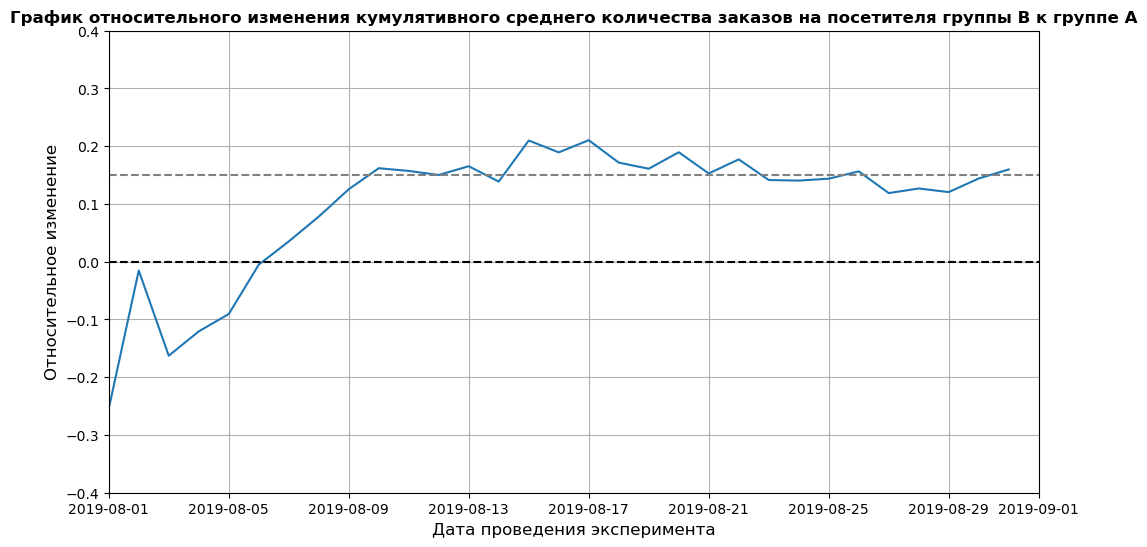

In [51]:
plt.figure(figsize=(12, 6)) # задаем размер графика

# cтроим график
plt.plot(data['date'], data['conversionB'] / data['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--') # добавляем ось X
plt.axhline(y=0.15, color='grey', linestyle='--') 
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4]) # задаем масштаб осей

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A',
          fontsize=12, fontweight="bold")
plt.xlabel('Дата проведения эксперимента', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.grid(True)
plt.show()

Почти с самого начала теста группа В лидирует по метрике. В первой половине месяца тестируемая группа показывала прирост относительно контрольной группы, но затем наблюдался спад и постепенное выравнивание или рост около прироста в 15%.   
В целом отношение среднего количества заказов на посетителя ещё не установилось, и, возможно, сейчас делать какие-либо выводы по тесту рано. Сперва стоит проанализировать аномалии, возможно, они изменят картину. 

**3.6. Построение точечного графика количества заказов по пользователям.**

In [54]:
# Найдем число заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorid', as_index=False) 
    .agg({'transactionid': 'nunique'})
)
ordersByUsers.columns = ['userid', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userid,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


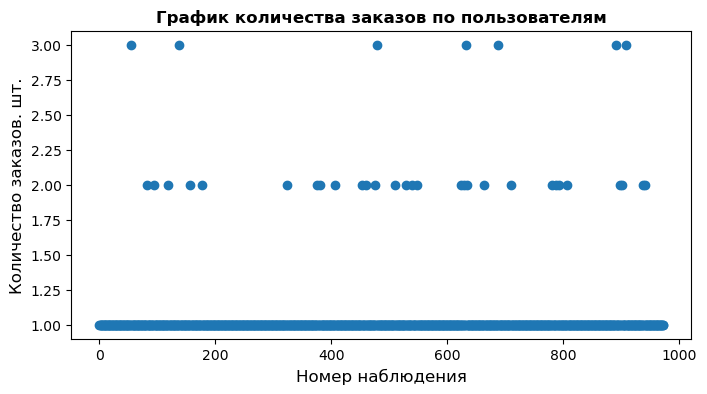

In [55]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

# строим точечный график
plt.figure(figsize=(8, 4)) # задаем размер графика

plt.scatter(x_values, ordersByUsers['orders'])

plt.title('График количества заказов по пользователям', fontsize=12, fontweight="bold")
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Количество заказов. шт.', fontsize=12)
plt.show()

Большинство покупателей заказывали только один раз. Пользователей, заказавших более двух раз совсем мало. Они вполне могут быть аномальными. Выясним это, посчитав выборочные перцентили.

**3.7. Вычисление 95-го и 99-го перцентиля количества заказов на пользователя. Выбор границы для определения аномальных пользователей.**

In [58]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей оформляли больше одного заказа и не более 1% - больше двух заказов.
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять 1% аномальных пользователей по ней. 

**3.8. Построение точечного графика стоимостей заказов.**

In [61]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionid,visitorid,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


На первой строчке таблицы `orders`, отсортированной по убыванию суммы заказа, оказался заказ почти на 1,3 млн.руб., что является явной аномалией

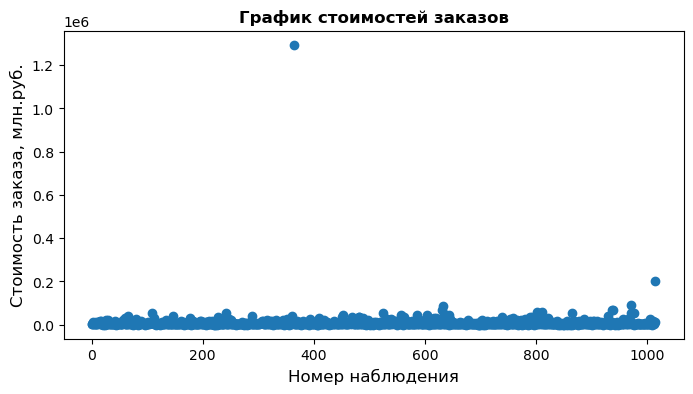

In [63]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(orders['revenue'])))

# строим точечный график
plt.figure(figsize=(8, 4)) # задаем размер графика

plt.scatter(x_values, orders['revenue']) 

plt.title('График стоимостей заказов', fontsize=12, fontweight="bold")
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Стоимость заказа, млн.руб.', fontsize=12)
plt.show()

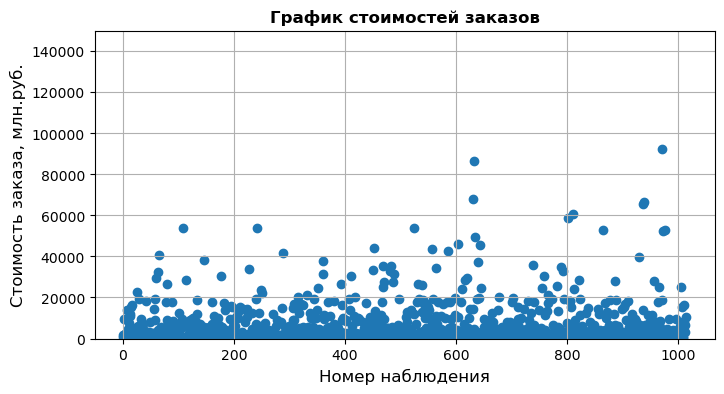

In [64]:
# построим точечный график увеличенного размера, ограничив стоимость 150000 руб.
plt.figure(figsize=(8, 4)) # задаем размер графика

plt.scatter(x_values, orders['revenue']) 
plt.ylim([0,150000])
plt.title('График стоимостей заказов', fontsize=12, fontweight="bold")
plt.xlabel('Номер наблюдения', fontsize=12)
plt.ylabel('Стоимость заказа, млн.руб.', fontsize=12)
plt.grid(True)
plt.show()

На графиках видны выбросы в районе 200000 рублей и 1300000 рублей. Остальные заказы стоимостью до 100000 рублей, причем большая часть из них до 20000 рублей.   
Найдем выборочные перцентили, чтобы определить границу отсеивания аномально больших заказов.

**3.9. Вычисление 95-го и 99-го перцентиля стоимости заказов. Выбор границы для определения аномальных заказов.**

In [67]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов превышали 26785 рублей и не более, чем у 1% заказов чек дороже 53904 рублей.  
Определим границу для определения аномальных заказов в размере 50000 рублей.

**3.10. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

Так как в "сырых" данных есть большие выбросы, для расчета статистической значимости различий в среднем количестве заказов на посетителя применим непараметрический метод - критерий Манна-Уитни.  

***Сформулируем гипотезы:***  
Нулевая:  статистически значимых различий в среднем числе заказов между группами нет.   
Альтернативная: различия в среднем числе заказов между группами есть.

In [71]:
# Создадим переменные ordersByUsersA и ordersByUsersB с указанием числа совершённых заказов на пользователя. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userid', 'orders']

# Объявляем переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 
# Их количество равно разнице между суммой посетителей и количеством записей о заказах
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Oтносительное различие среднего числа заказов группы B к А:',
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.01102
Oтносительное различие среднего числа заказов группы B к А: 0.160


***P-value меньше 0.05, значит отвергаем нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет. Анализ "сырых данных" показывает, что в среднем числе заказов между группами есть статистически значимые различия. Относительный прирост среднего числа заказов группы В к числу заказов группы А равен 16%***  
Однако, на результат вероятно повлияли выбросы и требуется посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

**3.11. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.**

***Сформулируем гипотезы:***  
Нулевая:  статистически значимых различий в среднем чеке заказа между группами нет.   
Альтернативная: различия в среднем чеке заказа между группами есть.

In [75]:
print('P-value:',
      '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Oтносительное различие среднего чека заказа группы B к А:',
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.829
Oтносительное различие среднего чека заказа группы B к А: 0.287


***P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Анализ "сырых данных" показывает, что в среднем чеке заказа между группами нет статистически значимых различий.  
Однако, относительное различие среднего чека между сегментами 28.7% в пользу группы В.***   
Приступим к анализу результатов A/B теста по "очищенным данным"

**3.12. Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.**

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 50 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.  

In [79]:
#Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders 
# и пользователей, совершивших заказы дороже 50 000 — usersWithExpensiveOrders
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], 99))]['userid'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], 99))]['userid'],
    ], 
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorid']

# Объединим их в таблице abnormalUsers, удалим дубликаты, отсортируем по возрастанию 
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print('Количество аномальных пользователей:', abnormalUsers.shape[0]) 

1099    148427295
33      249864742
58      611059232
1137    759473111
949     887908475
dtype: int64
Количество аномальных пользователей: 22


***Гипотезы:***  
Нулевая:  статистически значимых различий в среднем числе заказов между группами нет.   
Альтернативная: различия в среднем числе заказов между группами есть.

In [81]:
# В переменных sampleAFiltered и sampleBFiltered сохраняем очищенные данные о заказах(без аномальных пользователей) 
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('P-value:', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Oтносительное различие среднего числа заказов группы B к А:',
      '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.00561
Oтносительное различие среднего числа заказов группы B к А: 0.198


***Как и в случае с "сырыми" данными, P-value меньше 0.05, значит отвергаем нулевую гипотезу,  о том, что статистически значимых различий в среднем числе заказов между группами нет. Анализ "очищенных данных" также показывает, что в среднем количестве заказов между группами есть статистически значимые различия.   
Относительный прирост среднего числа заказов группы В к числу заказов группы А равен 19.8% (было 16% по "сырым" данным).***

**3.13.  Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.**

***Гипотезы:***  
Нулевая:  статистически значимых различий в среднем чеке заказа между группами нет.   
Альтернативная: различия в среднем чеке заказа между группами есть.

In [85]:
print(
    'P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Oтносительное различие среднего чека заказа группы B к А:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.939
Oтносительное различие среднего чека заказа группы B к А: 0.011


***Как и в случае с "сырыми" данными, P-value значительно больше 0.05. Значит, нулевую гипотезу не отвергаем. В среднем чеке заказа между группами нет статистически значимых различий.  
За счет удаления аномальных значений суммы заказа относительное различие среднего чека между сегментами уменьшилось с 28.7% на "сырых" данных до 1.1% на "очищенных" данных.***   

**3.14.Выводы и решение по результатам теста.** 

Обнаружены факты:  

    - Есть статистически значимые различия в среднем количестве заказов между группами как по "сырым", так и по данным после фильтрации. Относительный прирост количества заказов группы В больше, чем в группе А;    
      
      - В среднем чеке заказа между группами нет статистически значимых различий между группами как по "сырым", так и по данным после фильтрации;   
      
      - График различия среднего количества заказов между группами сообщает, что тестовая группа лидирует по кумулятивному среднему количеству заказов;  
      
      - График различия среднего чека говорит о том, что результаты группы B снижаются день ото дня, но в целом лучше, чем у контрольной группы.

***Исходя из обнаруженных фактов, тест следует остановить и признать победу тестовой группы В.*** 

## Общий вывод

В ходе реализации проекта была проведена приоритизация гипотез по ICE и по RICE, проанализированы результаты A/B-теста для увеличения выручки крупного интернет-магазина.

**Раздел 1:** ***В тройку наиболее приоритетных гипотез как по ICE, так и по RICE вошли две гипотезы:***

***1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (первое место в приоритете по RICE, затронет большее количество пользователей, так как её параметр reach 10 - максимально возможный)*** 

***2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (Оказалась наиболее стабильной и по ICE (2 приоритет) и по RICE (3 приоритет). Её стоит обязательно протестировать.)***

Лидирующая по ICE гипотеза "Запустить акцию, дающую скидку на товар в день рождения" оказалась лишь на 5-м месте в приоритете по RICE, т.к. затрагивает минимальное число клиентов (параметр reach равен 1).
  
**Раздел 2:** В процессе ***анализа A/B теста*** были построены графики кумулятивной выручки и среднего чека по группам, графики относительного изменения кумулятивного среднего чека и среднего количества заказов на посетителя группы B к группе A, проанализированы аномалии с помощью точечных графиков и определены границы аномальных заказов как по количеству (от 2 заказов), так и по сумме чека (50000 рублей). Посчитали статистическую значимость различий в среднем количестве заказов и среднем чеке на посетителя между группами по «сырым» и по "очищенным" данным.  
  
***Обнаружены статистически значимые различия в среднем количестве заказов в пользу тестируемой группы и отсутствие   статистически значимых различий в среднем чеке.***

***Исходя из обнаруженных фактов, тест следует остановить и признать победу тестовой группы В.***